This is the first in a series of posts that I plan on writing as I learn how to apply Bayesian methods to different topics/problems that I find interesting. In this post I go over how to use the Bayesian bootstrap to get measure of uncertainty for an NFL quarterback's (QB) yards per pass attempt (YPA).


## What is the Bayesian Bootstrap and how do we compute it?

Bootstrapping is a resampling technique that allows us to calculate the uncertainty for a given statistic of interest (e.g. mean, median, etc.).  In the classical bootstrap we construct these measures of uncertainty by first creating multiple datasets, called bootstrap samples, by sampling with replacement from the original data. Then for each of these newly generated samples, we calculate the statistic of interest and end up with an approximation of its distribution.

Here is an example of the classical bootstrap being used to construct an interval around a regression line:

In the classical bootstrap, sampling with replacement can be seen as [applying weights to our observations, based on the (normalized) counts we draw from a multinomial distribution](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/#its-the-bayesian-bootstrap-but-with-discrete-weights).  In the Bayesian bootstrap, instead of applying weights from a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) we apply weights from a uniform (flat) [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). ([Here's](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution-as-a-probability-distribution-over-the-k-%E2%88%92-1-dimensional-probability-simplex) an intuitive explanation of the Dirichlet distribution for those who don't know what it is). To create Bayesian bootstrap samples, we repeat the following procedure as many times as we'd like (the more times we repeat it the better):

1. Draw weights from a uniform Dirichlet distribution with the same dimension as the number of observations in the data.
    - **NOTE:** Here the uniform Dirichlet distribution acts as an uninformative prior.
2. If possible, calculate the statistic using the weights from the Dirichlet distribution.
3. Otherwise, if the statistic doesn’t directly use weights in its calculation do the following:
    1. Resample the data according to the weights drawn from the Dirichlet distribution.
        - **NOTE:** In this step we create as large of a sample as possible. It should as large as the original dataset.
    2. Use the resampled data to calculate the statistic.

The final distribution created by the Bayesian bootstrap is a [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) of the statistic of interest.

To get a better sense of the above procedure let’s code up our own Bayesian bootstrap function.

In [1]:
import numpy as np

def bayes_boot(X, statistic, n_samples1=1000, n_samples2=1000, weight_kwd=None,
               *args, **kwargs):
        
    # draw our weights from the uniform dirichlet distribution
    # [1]*len(X) is the dimension of the distribution
    # n_samples1 represents the number of bootstrap replications to perform
    # from the bayesian perspective think of it as the number of draws from the
    # posterior distribution
    # in terms of the classical bootstrap this is the number times the data is 
    # resampled
    weights = np.random.dirichlet([1]*len(X), n_samples1)
    
    # if the statistic function accepts weights, use them to calculate the 
    # bayesian bootstrap samples
    if weight_kwd is not None:
        samples = [statistic(X, *args, **{weight_kwd: w}, **kwargs) for w in weights]
    
    # otherwise we have to do a weighted resampling of the data, based on
    # the weights we drew from the dirichlet distribution
    else:
        samples = []
        for w in weights:
            # resample the indexes using the dirchlet weights
            # the greater n_sample2 is, the better
            sample_idx = np.random.choice(range(len(X)), p=w, size=n_samples2)
            X_resample = X[sample_idx]
            # calculate the statistic on the resampled data and append it
            # to our samples list
            samples.append(statistic(X, *args, **kwargs))

    return np.array(samples)

## Applying the Bayesian Boostrap to the NFL
Now that we have some knowledge of how the Bayesian bootstrap works, let’s use it to compare Drew Brees’ and Deshaun Watson’s mean YPA from last season.  Even though we made our own Bayesian bootstrap function, going forward we will use the [bayesian_bootstrap](https://github.com/lmc2179/bayesian_bootstrap) package for our analysis.

First let's import the remaining packages we will use.

In [9]:
%%capture
!pip install bayesian-bootstrap

In [2]:
# import the rest of the packages we will use
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import bayesian_bootstrap as bb
from scipy import stats
from astropy.utils import NumpyRNGContext

In [3]:
# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

Then let's set up our data. The play by play data comes from [Ron Yurko's](https://twitter.com/Stat_Ron) awesome [nflscrapR-data github repository](https://github.com/ryurko/nflscrapR-data).

In [4]:
# Read in and set up our data. 
pbp_df = pd.read_csv('pbp_2021.csv', low_memory=False)
rosters_df = pd.read_csv('rosters2021.csv')

In [5]:
pbp_df.filter(regex='pass_').columns

Index(['pass_length', 'pass_location', 'total_home_pass_epa',
       'total_away_pass_epa', 'total_home_pass_wpa', 'total_away_pass_wpa',
       'pass_attempt', 'pass_touchdown', 'pass_defense_1_player_id',
       'pass_defense_1_player_name', 'pass_defense_2_player_id',
       'pass_defense_2_player_name', 'pass_oe'],
      dtype='object')

In [7]:
rosters_df

,season,full_name,team,position,player_name,gsis_id
0,2021,Byron Murphy,ARI,CB,B.Murphy,00-0035236
1,2021,Breon Borders,ARI,CB,B.Borders,00-0033435
2,2021,Antonio Hamilton,ARI,CB,A.Hamilton,00-0032933
3,2021,Malcolm Butler,ARI,CB,M.Butler,00-0031218
4,2021,Picasso Nelson,ARI,CB,P.Nelson,00-0035368
...,...,...,...,...,...,...
5210,2021,KJ Maye,NaN,WR,K.Maye,00-0032653
5211,2021,Jehu Chesson,NaN,WR,J.Chesson,00-0033464
5212,2021,Marcus Simms,NaN,WR,M.Simms,00-0035701
5213,2021,Rashawn Scott,NaN,WR,R.Scott,00-0032621


In [18]:
# replace . with _
#pbp_df.columns = pbp_df.columns.str.replace('.', '_')

# keep all qb pass attempt
# first we keep the plays where a pass occured
# then we get the passer's position (along with their full name and GSIS_ID)
# in order to filter out all non-QB pass attempts
qb_pass_df = (pbp_df.query('pass_attempt == 1')
                    .merge(rosters_df[['gsis_id', 'full_name', 'position']], how='left', 
                           left_on='passer_id', right_on='gsis_id')
                    .query('position == "QB"'))

In [21]:
qb_pass_df.value_counts('full_name', ascending=False)

full_name
Tom Brady          838
Patrick Mahomes    776
Josh Allen         740
Derek Carr         722
Justin Herbert     709
                  ... 
C.J. Beathard        2
Brett Rypien         2
Marcus Mariota       2
David Blough         1
Feleipe Franks       1
Length: 94, dtype: int64

In [22]:
patty_df = qb_pass_df.loc[qb_pass_df.full_name == 'Patrick Mahomes']
josh_df = qb_pass_df.loc[qb_pass_df.full_name == 'Josh Allen']
herbie_df = qb_pass_df.loc[qb_pass_df.full_name == 'Justin Herbert']

In [23]:
# make sure only 1 player has the name
patty_df.gsis_id.nunique() == josh_df.gsis_id.nunique() == herbie_df.gsis_id.nunique()

True

Now that we have the data set up, let's calculate each player's YPA for the 2017 season.

In [33]:
#patty_df.filter(regex='full').columns

In [41]:
patty = [patty_df.yards_gained.sum(), patty_df.yards_gained.size, patty_df.full_name.unique().item()]
josh = [josh_df.yards_gained.sum(), josh_df.yards_gained.size, josh_df.full_name.unique().item()]
herbie = [herbie_df.yards_gained.sum(), herbie_df.yards_gained.size, herbie_df.full_name.unique().item()]

In [46]:
print(f'{patty[2]} threw for {patty[0]:.0f} total yards on {patty[1]} pass attempts, averaging {(patty[0]/patty[1]):.3f} yards per attempt')
print(f'{josh[2]} threw for {josh[0]:.0f} total yards on {josh[1]} pass attempts, averaging {(josh[0]/josh[1]):.3f} yards per attempt')
print(f'{herbie[2]} threw for {herbie[0]:.0f} total yards on {herbie[1]} pass attempts, averaging {(herbie[0]/herbie[1]):.3f} yards per attempt')

Patrick Mahomes threw for 5435 total yards on 776 pass attempts, averaging 7.004 yards per attempt
Josh Allen threw for 4868 total yards on 740 pass attempts, averaging 6.578 yards per attempt
Justin Herbert threw for 4810 total yards on 709 pass attempts, averaging 6.784 yards per attempt


To construct our Bayesian bootstrap samples for each QB, we pass the yards gained on each of their pass attempts to `bayesian_bootstrap`'s `mean` function and set the number of replications we want.

In [47]:
# for reproducibility, set the seed within this context
with NumpyRNGContext(42):
    patty_bootstrap = bb.mean(patty_df.yards_gained, n_replications=10000)
    josh_bootstrap = bb.mean(josh_df.yards_gained, n_replications=10000)
    herbie_bootstrap = bb.mean(herbie_df.yards_gained, n_replications=10000)

`mean` returns us a `list` with the mean for each bootstrapped sample.  This `list` is the posterior distribution over the probable mean values of the data we are interested in.

In [48]:
# the mean YPA for the first 5 bootstrapped samples
patty_bootstrap[:5]

array([6.64691817, 6.77476447, 7.63072175, 6.8382919 , 7.03803871])

In [49]:
# there are a total of 10000 means, 1 for each replication
len(patty_bootstrap)

10000

It's pretty straightforward to plot the posterior with `seaborn`'s `distplot` function.

In [77]:
def create_hist_(array, name='name', color='salmon', *args, **kwargs):
    df = pd.DataFrame({f'{name}': patty_bootstrap})
    ax = sns.displot(df, x=f'{name}', kind='hist', kde=True, fill=True, aspect=1.5, color=color)
    ax.set(*args, **kwargs)
    plt.show()

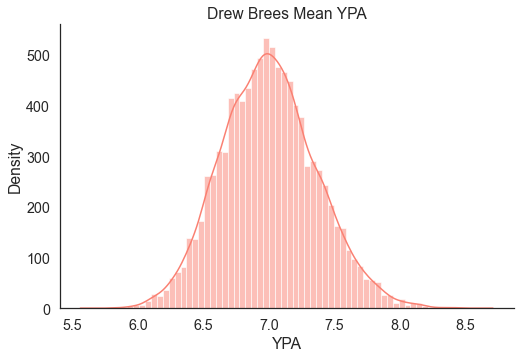

In [78]:
create_hist_(patty_bootstrap, xlabel='YPA', ylabel='Density', title = 'Patrick Mahomes Mean YPA')

We can also construct a credible interval. `bayesian_bootstrap` provides two methods to do that, the `central_credible_interval` and the `highest_density_interval` functions. When constructing intervals for unimodal (i.e. it has one peak), symmetric distribution, both methods should give you similar intervals. But if the distribution is multimodal (i.e. it has multiple peaks representing well separated modes), the `central_credible_interval` function will return a single interval while the the `highest_density_interval` will return multiple disjointed intervals centered around the modes of the distribution. A good discussion on these two methods of constructing credible intervals can be found [here](https://stats.stackexchange.com/questions/240749/how-to-find-95-credible-interval) and [here](https://stats.stackexchange.com/questions/24588/quantile-intervals-vs-highest-posterior-density-intervals). Here we will use the `highest_density_interval` function to calculate our credible intervals.

In [81]:
# Calculate a 95% HDI
patty_ci_low, patty_ci_hi = bb.highest_density_interval(patty_bootstrap)
print(f'Low CI: {patty_ci_low:.3f} \t High CI: {patty_ci_hi:.3f}')

Low CI: 6.305 	 High CI: 7.724


In [86]:
pd.DataFrame(patty_bootstrap).columns

RangeIndex(start=0, stop=1, step=1)

In [103]:
def create_hist_2(array, *args, **kwargs):
    _ci_low, _ci_hi = bb.highest_density_interval(array)
    df = pd.DataFrame({'boot': array})
    ax = sns.histplot(df['boot'], kde=True, stat="density")
    ax.plot([_ci_low, _ci_hi], [0, 0], linewidth=10, c='k', marker='o')
    ax.set(xlabel='YPA', ylabel='Density', *args, **kwargs)
    plt.legend(labels=['95% HDI'])
    plt.show()

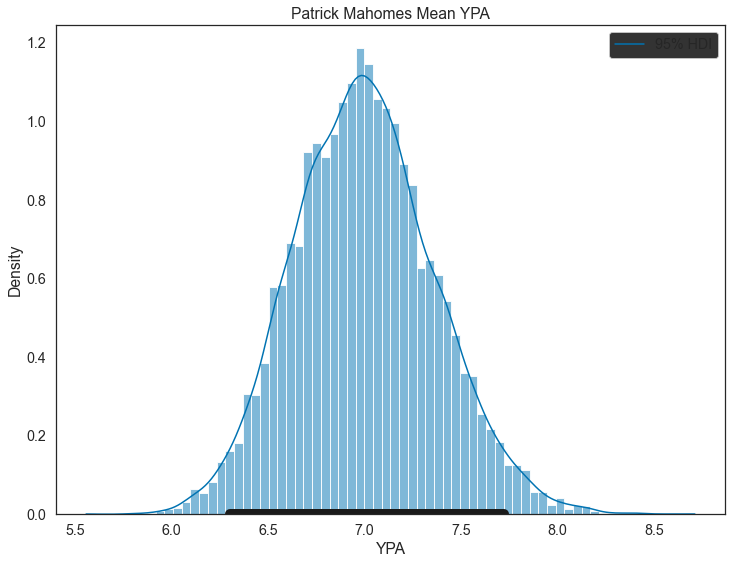

In [104]:
create_hist_2(patty_bootstrap, title = 'Patrick Mahomes Mean YPA')

Brees' 95% HDI is between 7.33 and 9.04 YPA, which means that according to our model (you can think  of the Bayesian bootstrap as [poor man's model](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/#some-final-thoughts)) and the data we've observed (Brees' passes), there is a 95% chance that Brees' mean YPA is between 7.33 YPA and 9.04 YPA. 

Now let's also plot Watson's posterior distribution and compare the distributions for both QBs.

In [114]:
sns.color_palette("mako", as_cmap=False, n_colors=3)[0]

(0.24423453, 0.20678459, 0.41985299)

In [115]:
def create_hist_3(array1, array2, qb1_name = 'Name', qb2_name = 'Name', *args, **kwargs):
    _ci_low1, _ci_hi1 = bb.highest_density_interval(array1)
    _ci_low2, _ci_hi2 = bb.highest_density_interval(array2)
    df = pd.DataFrame({'boot1': array1, 'boot2': array2})
    
    ax = sns.histplot(df['boot1'], kde=True, color = '#b3cde3')
    ax = sns.histplot(df['boot2'], kde=True, color = '#ccebc5')
    
    #ax = sns.histplot(df['boot'], kde=True, stat="density")
    #ax.plot([_ci_low, _ci_hi], [0, 0], linewidth=10, c='k', marker='o')
    ax.set(xlabel='YPA', ylabel='Density', *args, **kwargs)
    plt.legend(labels = [f'{qb1_name}', f'{qb2_name}'])
    plt.show()

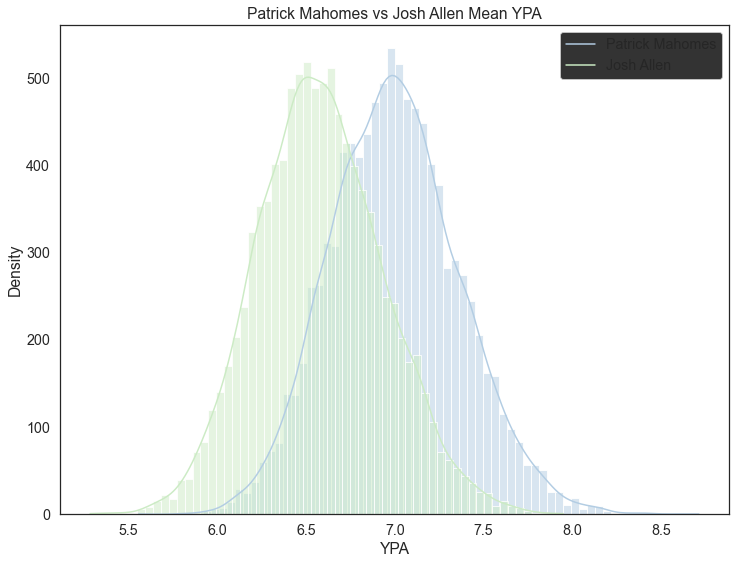

In [116]:
create_hist_3(patty_bootstrap, josh_bootstrap, qb1_name= 'Patrick Mahomes', qb2_name= 'Josh Allen', title = 'Patrick Mahomes vs Josh Allen Mean YPA')

Watson's posterior distribution is shorter and wider than Brees', which indicates that there is more uncertainty with respect to Watson's mean YPA. 

We can also measure the uncertainty in the difference between the player's YPA by subtracting their posteriors.

In [117]:
# calculate the posterior for the difference
ypa_diff1 = np.array(patty_bootstrap) - np.array(josh_bootstrap)
ypa_diff2 = np.array(patty_bootstrap) - np.array(herbie_bootstrap)
ypa_diff3 = np.array(josh_bootstrap) - np.array(herbie_bootstrap)
# hdi
ypa_diff_ci_low1, ypa_diff_ci_hi1 = bb.highest_density_interval(ypa_diff1)
ypa_diff_ci_low2, ypa_diff_ci_hi2 = bb.highest_density_interval(ypa_diff2)
ypa_diff_ci_low3, ypa_diff_ci_hi3 = bb.highest_density_interval(ypa_diff3)

In [121]:
print(f'Mean of Posterior 1: {ypa_diff1.mean():.3f} \t Low CI: {ypa_diff_ci_low1:.3f} \t High CI: {ypa_diff_ci_hi1:.3f}')
print(f'Mean of Posterior 1: {ypa_diff2.mean():.3f} \t Low CI: {ypa_diff_ci_low2:.3f} \t High CI: {ypa_diff_ci_hi2:.3f}')
print(f'Mean of Posterior 1: {ypa_diff3.mean():.3f} \t Low CI: {ypa_diff_ci_low3:.3f} \t High CI: {ypa_diff_ci_hi3:.3f}')

Mean of Posterior 1: 0.417 	 Low CI: -0.597 	 High CI: 1.401
Mean of Posterior 1: 0.222 	 Low CI: -0.856 	 High CI: 1.208
Mean of Posterior 1: -0.195 	 Low CI: -1.209 	 High CI: 0.804


In [124]:
def mean_diff_hist_(array1, array2, qb1_name = 'Name', qb2_name = 'Name', *args, **kwargs):    
    diff_ = np.array(array1) - np.array(array2)
    ci_low_, hi_low_ = bb.highest_density_interval(diff_)
    df = pd.DataFrame({'boot1': diff_})
    
    ax = sns.histplot(df['boot1'], kde=True, color = '#b3cde3')
    
    #ax = sns.histplot(df['boot'], kde=True, stat="density")
    ax.plot([ci_low_, hi_low_], [0, 0], linewidth=10, c='k', marker='o')
    ax.set(
        title = "The difference between f'{qb1_name}'\'s and f'{qb2_name}'\'s mean YPA",
        xlabel='YPA', ylabel='Density', *args, **kwargs)
    plt.legend(labels = ['95% HDI'])
    plt.show()

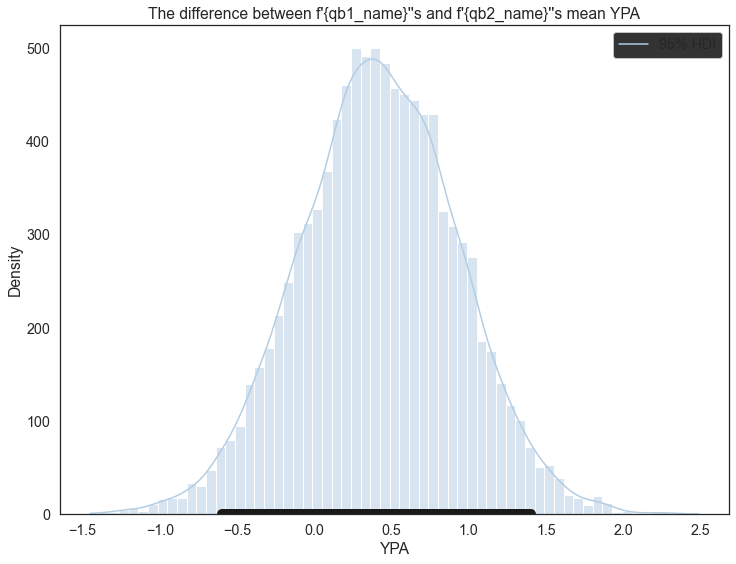

In [125]:
mean_diff_hist_(patty_bootstrap, josh_bootstrap, qb1_name= 'Patrick Mahomes', qb2_name= 'Josh Allen')

So the mean of the posterior is about 0.2 and the 95% HDI is pretty wide, ranging from -1.5 to about 2, indicating to us that we can't really be certain that the two player's mean YPA were that different last season. 

We can actually calculate the probability that Watson's mean YPA was greater than Brees' mean YPA by measuring the proportion of values greater than 0 in the above distribution.

In [126]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0

print(f'Proportion of values in the distribution that are greater than 0: {((ypa_diff1 > 0).sum() / ypa_diff1.shape[0]):.3f}')
print(f'Proportion of values in the distribution that are greater than 0: {((ypa_diff2 > 0).sum() / ypa_diff2.shape[0]):.3f}')
print(f'Proportion of values in the distribution that are greater than 0: {((ypa_diff3 > 0).sum() / ypa_diff3.shape[0]):.3f}')

Proportion of values in the distribution that are greater than 0: 0.794
Proportion of values in the distribution that are greater than 0: 0.663
Proportion of values in the distribution that are greater than 0: 0.346


So it looks like about 58% of the distribution is greater than 0, which doesn't give us much confidence that Watson's mean YPA was greater than Brees'.

## Comparing multiple players

In addition to Brees and Watson, we can use the Bayesian bootstrap to compare other QBs.

In [140]:
qb_list = ['Tom Brady',
 'Patrick Mahomes',
 'Josh Allen',
 'Justin Herbert',
 'Matthew Stafford',
 'Joe Burrow',
 'Ryan Tannehill',
 'Aaron Rodgers',
 'Carson Wentz',
 'Kirk Cousins']

selected_qb_ = qb_pass_df.loc[qb_pass_df.full_name.isin(qb_list)]

# make sure that each player only has one unique id
selected_qb_.groupby(['full_name', 'gsis_id']).size()

full_name         gsis_id   
Aaron Rodgers     00-0023459    592
Carson Wentz      00-0032950    552
Joe Burrow        00-0036442    652
Josh Allen        00-0034857    740
Justin Herbert    00-0036355    709
Kirk Cousins      00-0029604    587
Matthew Stafford  00-0026498    691
Patrick Mahomes   00-0033873    776
Ryan Tannehill    00-0029701    603
Tom Brady         00-0019596    838
dtype: int64

In [ ]:
selected_qb_.yards_gained

In [143]:
# this is a helper function that we can use to create our bayesian booststrap
# samples for each player, calculate the HDI a
def create_bb_ypa_df(group, n_replications=10000, alpha=0.05,
                     col='yards_gained'):
    # construct the posterior
    posterior = bb.mean(group[col], n_replications=n_replications)
    # construct HDI
    lower_ci, upper_ci = bb.highest_density_interval(posterior, alpha=0.05)
    # get the players observed YPA
    pass_yards = group[col].sum()
    pass_attempts = len(group[col])
    mean_ypa = pass_yards / pass_attempts
    # the data we want
    data = pd.Series({'posterior': posterior,
                      'lower_ci': lower_ci,
                      'upper_ci': upper_ci,
                      
                      # these will make constructing the plot to to compare
                      # the players 95% HDI easier
                      'lower_ci_diff': lower_ci - mean_ypa,
                      'upper_ci_diff': upper_ci - mean_ypa,
                      'est_mean_ypa': np.mean(posterior),
                      'pass_attempts': pass_attempts,
                      'pass_yards': pass_yards,
                      'obs_mean_ypa': mean_ypa})
    return data

In [144]:
# construct posteriors for each player by grouping by each player and applying
# the above helper function
# we should get a dataframe with each player's info
with NumpyRNGContext(42):
    ypa_df = (selected_qb_.groupby(['gsis_id', 'full_name'])
                            .apply(create_bb_ypa_df)
                            .reset_index())

In [145]:
# take a look at the dataframe
ypa_df

,gsis_id,full_name,posterior,lower_ci,upper_ci,lower_ci_diff,upper_ci_diff,est_mean_ypa,pass_attempts,pass_yards,obs_mean_ypa
0,00-0019596,Tom Brady,"[7.387598124298845, 6.697418629304089, 7.43423...",6.172003,7.466769,-0.657353,0.637413,6.829703,838,5723.0,6.829356
1,00-0023459,Aaron Rodgers,"[6.593848731892446, 6.671682856887213, 6.58256...",6.096864,7.801012,-0.867663,0.836485,6.957704,592,4123.0,6.964527
2,00-0026498,Matthew Stafford,"[8.370451545111735, 7.8044700140265295, 7.0157...",6.666420,8.428276,-0.854564,0.907292,7.526786,691,5197.0,7.520984
3,00-0029604,Kirk Cousins,"[7.120736364673785, 6.916116595197908, 6.55733...",6.068463,7.716339,-0.786733,0.861143,6.863229,587,4024.0,6.855196
4,00-0029701,Ryan Tannehill,"[6.214516899906934, 5.821038057672169, 5.69117...",5.268516,6.743867,-0.738117,0.737234,6.007145,603,3622.0,6.006633
5,00-0032950,Carson Wentz,"[6.048443343126532, 6.3436408149145, 6.3990376...",5.217240,6.885901,-0.833485,0.835176,6.048799,552,3340.0,6.050725
6,00-0033873,Patrick Mahomes,"[7.424023599985469, 6.663300057243828, 6.97159...",6.313364,7.732361,-0.690502,0.728495,7.004966,776,5435.0,7.003866
7,00-0034857,Josh Allen,"[6.747082952730407, 6.700217702005078, 6.26820...",5.879132,7.255868,-0.699246,0.677490,6.570892,740,4868.0,6.578378
8,00-0036355,Justin Herbert,"[7.299651117048418, 6.978376469716656, 6.60609...",6.099229,7.490177,-0.684974,0.705974,6.785368,709,4810.0,6.784203
9,00-0036442,Joe Burrow,"[7.702020994927122, 7.386035288873531, 7.92530...",6.404869,8.231138,-0.877340,0.948929,7.294119,652,4748.0,7.282209


We can compare each player's posterior by plotting their 95% HDI like so:

In [149]:
# league average ypa as a comparison point
ypa = qb_pass_df.yards_gained.sum() / qb_pass_df.yards_gained.size
# in order to plot the HDI as error bars around a player's posterior mean
# we have to do this transformation of the data and pass it to 
# matplotlib's errorbar function parameter xerr
ypa_ci = np.array(list(zip(-ypa_df.lower_ci_diff, ypa_df.upper_ci_diff))).T


In [157]:
ypa_df = ypa_df.sort_values(by=['est_mean_ypa'], ascending=True)

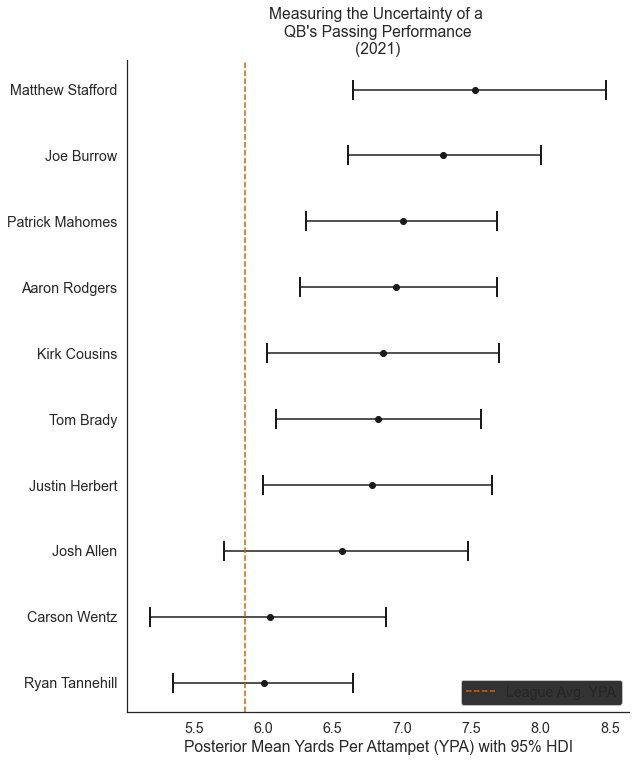

In [158]:
# now create the plot
plt.figure(figsize=(9,12))
plt.errorbar('est_mean_ypa', 'full_name', xerr=ypa_ci, data=ypa_df, fmt='ko', 
             capthick=2, capsize=10, label=None)
plt.axvline(ypa, color='r', linestyle='--', label='League Avg. YPA')
plt.xlabel('Posterior Mean Yards Per Attampet (YPA) with 95% HDI')
plt.title('Measuring the Uncertainty of a \nQB\'s Passing Performance\n(2021)')
plt.legend()
sns.despine()
plt.show()

We can also create ridgeline plots (formerly known as [joyplots](http://serialmentor.com/blog/2017/9/15/goodbye-joyplots)) to plot out the full posterior distribution for each player.

In [161]:
# explode list of psoteriors to make it easier to plot joy plot
# https://stackoverflow.com/questions/42012152/unstack-a-pandas-column-containing-lists-into-multiple-rows
ypa_posterior_df = pd.DataFrame({'Player': np.repeat(ypa_df.full_name, 
                                                     ypa_df.posterior.str.len()),
                                 'posterior': np.concatenate(ypa_df.posterior.values)})

# this code is based on the code from the seaborn documentation
# https://seaborn.pydata.org/examples/kde_joyplot.html
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.65, .2, label, fontweight="bold", color=color, 
            transform=ax.transAxes)

# use team colors for each player
tm_colors = ['#002244', '#9F8958', '#0B2265', '#FFB612', '#A71930', 
             '#69BE28', '#000000', '#B3995D', '#00338D', '#03202F']

In [ ]:
# initialize the FacetGrid object
g = sns.FacetGrid(ypa_posterior_df, row="Player", hue="Player", aspect=4.5, 
                  height=1.3, palette=tm_colors)
# plot each player's posterior distribution
g.map(sns.kdeplot, "posterior", clip_on=False, shade=True, lw=2)
# label each distribution with the player's name
g.map(label, "posterior")
# add the the line representing the league avg YPA
g.map(plt.axvline, x=ypa, color='k', linestyle='--')
# Adjust the spacing for each player's kde plot so that they are veritcally 
# adjacent to one another
g.fig.subplots_adjust(hspace=0)
# # Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
# add legend, title and xlable
ax1 = g.axes[0, 0]
ax1.legend([ax1.lines[1]], ['League Avg. YPA'])
ax1.set_title('Measuring the Uncertainty of a \nQB\'s Passing Performance\n(2021)')
plt.xlabel('Yards Per Attempt (YPA)');

Hopefully you found this blog post helpful.  If you see any mistakes, have any questions or suggestions  [or if you're hiring :)] you can email me at savvas.tjortjoglou@gmail.com, hit me up on Twitter [@savvastj](https://twitter.com/savvastj), or just leave a comment below.

If you like this post and want to support my blog you can check out my patreon page [here](https://www.patreon.com/savvastj).


## Resources

For a deeper dive into the Bayesian bootstrap I suggest reading Rasmus Bååth's series of blog posts on the topic. His conference talk is also worth watching. It’s only 15 minutes and he does a good job explaining both the classical bootstrap and the Bayesian bootstrap.

His blog posts:
- [The Non-parametric Bootstrap as a Bayesian Model](http://sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/)
- [Easy Bayesian Bootstrap in R](http://www.sumsar.net/blog/2015/07/easy-bayesian-bootstrap-in-r/)
- [bayesboot: An R package for doing the Bayesian bootstrap](http://www.sumsar.net/blog/2016/02/bayesboot-an-r-package/)

The video of his talk:
- [bayesboot: An R package for easy Bayesian bootstrapping](https://www.youtube.com/watch?v=VceFc5hsMw8&t=)

Here are links to github repositories for the R package `bayesboot` and the Python package `bayesian_bootstrap':
- [bayesboot](https://github.com/rasmusab/bayesboot)
- [bayesian_bootstrap](https://github.com/lmc2179/bayesian_bootstrap)

You can find the notebook and the data used for this post on [github](https://github.com/savvastj/nfl_bayesian_bootstrap).